## Characterization of Bayesian Posterior Densities

In [1]:
from mpart import *
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import scipy.stats
import copy
from scipy.stats import multivariate_normal
import time

print('Kokkos is using', Concurrency(), 'threads')

ModuleNotFoundError: No module named 'mpart'

 A way construct a transport map is from an unnormalized density. One situation where we know the probality density function up to a normalization constant is when modeling inverse problems with Bayesian inference.

For an inverse problem, the objective is to characterize the value of some parameters $\boldsymbol{\theta}$ of a given system, knowing some the value of some noisy observations $\mathbf{y}$.

With Bayesian inference, the characterization of parameters $\boldsymbol{\theta}$ is done via a *posterior* density $\pi(\boldsymbol{\theta}|\mathbf{y})$. This density characterizes the distribution of the parameters knowing the value of the observations.

Using Bayes' rule, the posterior can decomposed into the product of two probability densities:

1.   The prior density $\pi(\boldsymbol{\theta})$ which is used to enforce any *a priori* knowledge about the parameters.
2.   The likelihood function $\pi(\mathbf{y}|\boldsymbol{\theta})$. This quantity can be seen as a function of $\boldsymbol{\theta}$ and gives the likelihood that the considered system produced the observation $\mathbf{y}$ for a fixed value of $\boldsymbol{\theta}$. When the model that describes the system is known in closed form, the likelihood function is also knwon in closed form.

Hence, the posterior density reads:

$$
\pi(\boldsymbol{\theta}|\mathbf{y}) = \frac{1}{c} \pi(\mathbf{y}|\boldsymbol{\theta}) \pi(\boldsymbol{\theta})
$$

where $c = \int \pi(\mathbf{y}|\boldsymbol{\theta}) \pi(\boldsymbol{\theta}) d\theta$ is an normalizing constant that ensures that the product of the two quantities is a proper density.  Typically, the integral in this definition cannot be evaluated and $c$ is assumed to be unknown.

As in Parts 1 and 2 above, we will accomplish this by defining an objective function that measures the difference between $\pi(\boldsymbol{\theta}|\mathbf{y})$ and the map-induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ and then find the map parameters $\mathbf{w}$ that minimize this objective function.  Here, the objective function will be the KL divergence between the map-induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ and the posterior density $\pi(\boldsymbol{\theta}|\mathbf{y})$.  Some details are provided below but interested readers should consult [[Marzouk et al., 2016]](https://arxiv.org/pdf/1602.05023.pdf) or [[Moselhy and Marzouk, 2012]](https://arxiv.org/pdf/1109.1516.pdf).

##### Problem description

Knowing the closed form of unnormalized posterior $\bar{\pi}(\boldsymbol{\theta} |\mathbf{y})= \pi(\mathbf{y}|\boldsymbol{\theta})\pi(\boldsymbol{\theta})$, the objective is to find a map-induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ that is a good approximation to the posterior $\pi(\boldsymbol{\theta} |\mathbf{y})$.

In order to characterize this posterior density, one method is to build a transport map.

For the map from unnormalized density estimation, the objective function reads

$$
J(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^N \left( \log\pi\left(T(\mathbf{z}^i;\mathbf{w})\right) + \log  \text{det }\nabla_\mathbf{z} T(\mathbf{z}^i;\mathbf{w})\right), \,\,\, \mathbf{z}^i \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d),
$$

where $T$ is the transport map pushing forward the standard normal $mathcal{N}(\mathbf{0},\mathbf{I}_d)$ to the target density $\pi(\mathbf{x})$, which will be the the posterior density in Bayesian inference applications.  The gradient of this objective function reads

$$
\nabla_\mathbf{w} J(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^N \left( \nabla_\mathbf{w} T(\mathbf{z}^i;\mathbf{w}).\nabla_\mathbf{x}\log\pi\left(T(\mathbf{z}^i;\mathbf{w})\right) + \nabla_{\mathbf{w}}\log  \text{det }\nabla_\mathbf{z} T(\mathbf{z}^i;\mathbf{w})\right), \,\,\, \mathbf{z}^i \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d).
$$

#### Example: Biochemical Oxygen Demand (BOD) model

To illustrate the process describe above, we consider the BOD inverse problem described in [[Marzouk et al., 2016]](https://arxiv.org/pdf/1602.05023.pdf).   The goal is to estimate $2$ coefficients in a time-dependent model of oxygen demand, which is used as an indication of biological activity in a water sample.

The time dependent forward model is defined as

$$
\mathcal{B}(t) = A(1-\exp(-Bt))+\mathcal{E},
$$

where

$$
\begin{aligned}
\mathcal{E} & \sim \mathcal{N}(0,1e-3)\\
A & = \left[0.4 + 0.4\left(1 + \text{erf}\left(\frac{\theta_1}{\sqrt{2}} \right)\right) \right]\\
B & = \left[0.01 + 0.15\left(1 + \text{erf}\left(\frac{\theta_2}{\sqrt{2}} \right)\right) \right]
\end{aligned}
$$

The objective is to characterize the posterior density of parameters $\boldsymbol{\theta}=(\theta_1,\theta_2)$ knowing observation of the system at time $t=\left\{1,2,3,4,5 \right\}$ i.e. $\mathbf{y} = (\mathcal{B}(1),\mathcal{B}(2),\mathcal{B}(3),\mathcal{B}(4),\mathcal{B}(5))$.

##### Deterministic model implementation

In [23]:
def forward_model(p1,p2,t):
  A = 0.4+0.4*(1+scipy.special.erf(p1/np.sqrt(2)))
  B = 0.01+0.15*(1+scipy.special.erf(p2/np.sqrt(2)))
  out = A*(1-np.exp(-B*t))
  return out

def grad_x_forward_model(p1,p2,t):
  A = 0.4+0.4*(1+scipy.special.erf(p1/np.sqrt(2)))
  B = 0.01+0.15*(1+scipy.special.erf(p2/np.sqrt(2)))
  dAdx1 = 0.31954*np.exp(-0.5*p1**2)
  dBdx2 = 0.119683*np.exp(-0.5*p2**2)
  dOutdx1 = dAdx1*(1-np.exp(-B*t))
  dOutdx2 = t*A*dBdx2*np.exp(-t*B)
  return np.vstack((dOutdx1,dOutdx2))

##### Likelihood function implementation

In [24]:
def log_likelihood(std_noise,t,yobs,p1,p2):
  y = forward_model(p1,p2,t)
  log_lkl = -np.log(np.sqrt(2*np.pi)*std_noise)-0.5*((y-yobs)/std_noise)**2
  return log_lkl

def grad_x_log_likelihood(std_noise,t,yobs,p1,p2):
  y = forward_model(p1,p2,t)
  dydx = grad_x_forward_model(p1,p2,t)
  grad_x_lkl = (-1/std_noise**2)*(y - yobs)*dydx
  return grad_x_lkl

##### Unnormalized posterior density and gradient

In [25]:
def log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,p1,p2):
  log_prior1 = -np.log(np.sqrt(2*np.pi)*std_prior1)-0.5*(p1/std_prior1)**2
  log_prior2 = -np.log(np.sqrt(2*np.pi)*std_prior2)-0.5*(p2/std_prior2)**2
  log_posterior = log_prior1+log_prior2
  for k,t in enumerate(list_t):
    log_posterior += log_likelihood(std_noise,t,list_yobs[k],p1,p2)
  return log_posterior

def grad_x_log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,p1,p2):
  grad_x1_prior = -(1/std_prior1**2)*(p1)
  grad_x2_prior = -(1/std_prior2**2)*(p2)
  grad_x_prior = np.vstack((grad_x1_prior,grad_x2_prior))
  grad_x_log_posterior = grad_x_prior 
  for k,t in enumerate(list_t):
    grad_x_log_posterior += grad_x_log_likelihood(std_noise,t,list_yobs[k],p1,p2)
  return grad_x_log_posterior

##### Observational data

In [26]:
list_t = np.array([1,2,3,4,5])
list_yobs = np.array([0.18,0.32,0.42,0.49,0.54])

std_noise = np.sqrt(1e-3)
std_prior1 = 1
std_prior2 = 1

Visualization of the **unnormalized** posterior density:

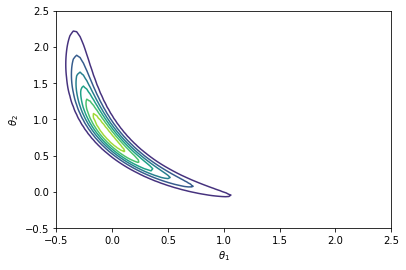

In [27]:
Ngrid = 100
x = np.linspace(-0.5, 2.5, Ngrid)
y = np.linspace(-0.5, 2.5, Ngrid)
X, Y = np.meshgrid(x, y)

Z = log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,X.flatten(),Y.flatten())
Z = np.exp(Z.reshape(Ngrid,Ngrid))


fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
plt.show()

#### Definition of the objective function:

In [28]:
def grad_x_log_target(x):
  out = grad_x_log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,x[0,:],x[1,:])
  return out

def log_target(x):
  out = log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,x[0,:],x[1,:])
  return out

def obj(coeffs, tri_map,x):
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)
    map_of_x = tri_map.Evaluate(x)
    rho_of_map_of_x = log_target(map_of_x)
    log_det = tri_map.LogDeterminant(x)
    return -np.sum(rho_of_map_of_x + log_det)/num_points

def grad_obj(coeffs, tri_map, x):
    num_points = x.shape[1]
    tri_map.SetCoeffs(coeffs)
    map_of_x = tri_map.Evaluate(x)
    sensi = grad_x_log_target(map_of_x)
    grad_rho_of_map_of_x = tri_map.CoeffGrad(x, sensi) 
    grad_log_det = tri_map.LogDeterminantCoeffGrad(x)
    return -np.sum(grad_rho_of_map_of_x + grad_log_det, 1)/num_points

In [29]:
#Draw reference samples
N=5000
Xtrain = np.random.randn(2,N)

#### Map parametrization and optimization:

In [30]:
# Set-up map and initize map coefficients
opts = MapOptions()

map_order = 3
tri_map = CreateTriangular(2,2,map_order,opts)
coeffs = np.zeros(tri_map.numCoeffs)
tri_map.SetCoeffs(coeffs)

options={'gtol': 1e-2, 'disp': True}
res = scipy.optimize.minimize(obj, tri_map.CoeffMap(), args=(tri_map, Xtrain), jac=grad_obj, method='BFGS', options=options)


Optimization terminated successfully.
         Current function value: -6.234015
         Iterations: 31
         Function evaluations: 34
         Gradient evaluations: 34


#### Comparing contours of approximate posterior and true unnormalized posterior

In [31]:
def push_forward_pdf(tri_map,rho,x):
  xinv = tri_map.Inverse(x,x)
  log_det_grad_x_inverse = - tri_map.LogDeterminant(xinv)
  log_pdf = rho.logpdf(xinv.T)+log_det_grad_x_inverse
  return np.exp(log_pdf)

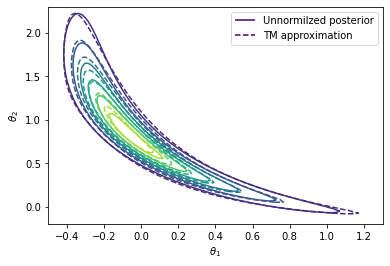

In [32]:
Ngrid = 100
x = np.linspace(-0.5, 1.3, Ngrid)
y = np.linspace(-0.2, 2.3, Ngrid)
xx, yy = np.meshgrid(x, y)

xx_eval = np.vstack((xx.flatten(),yy.flatten()))
Z2 = push_forward_pdf(tri_map,rho,xx_eval)
Z2 = Z2.reshape(Ngrid,Ngrid)

Z = log_posterior(std_noise,std_prior1,std_prior2,list_t,list_yobs,xx.flatten(),yy.flatten())
Z = np.exp(Z.reshape(Ngrid,Ngrid))

fig, ax = plt.subplots()
CS1 = ax.contour(xx, yy, Z)
CS2 = ax.contour(xx, yy, Z2,linestyles='dashed')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
ax.legend([h1[0], h2[0]], ['Unnormilzed posterior', 'TM approximation'])
plt.show()

### Drawing samples from approximate posterior

Once the transport map from reference to unnormalized posterior is estimated it can be used to sample from the posterior to characterize the Bayesian inference solution. 

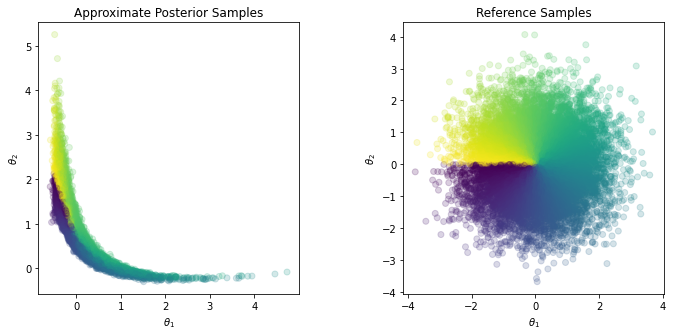

In [33]:
Znew = np.random.randn(2,15000)
colors = np.arctan2(Znew[1,:],Znew[0,:])

Xpost = tri_map.Evaluate(Znew)

fig,axs = plt.subplots(ncols=2,figsize=(12,5))
axs[0].scatter(Xpost[0,:],Xpost[1,:], c=colors, alpha=0.2)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlabel(r'$\theta_1$')
axs[0].set_ylabel(r'$\theta_2$')
axs[0].set_title('Approximate Posterior Samples')

axs[1].scatter(Znew[0,:],Znew[1,:], c=colors, alpha=0.2)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlabel(r'$\theta_1$')
axs[1].set_ylabel(r'$\theta_2$')
axs[1].set_title('Reference Samples')


plt.show()

Posterior mean:

In [34]:
X_mean = np.mean(Xpost,1)
print('Mean a posteriori: '+str(X_mean))

Mean a posteriori: [0.04165561 0.91279372]


One-dimensional marginals histograms:

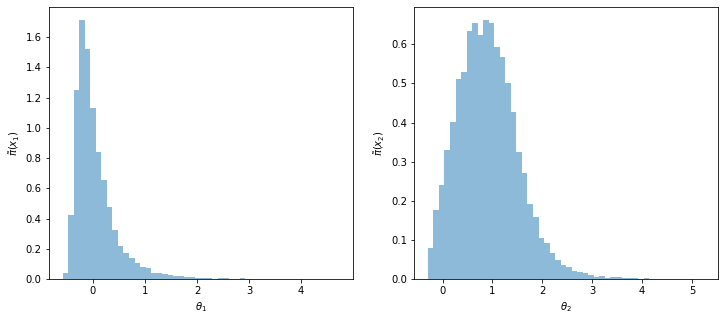

In [35]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(Xpost[0,:], 50, alpha=0.5, density=True)
ax[0].set_xlabel(r'$\theta_1$')
ax[0].set_ylabel(r'$\tilde{\pi}(x_1)$')
ax[1].hist(Xpost[1,:], 50, alpha=0.5, density=True)
ax[1].set_xlabel(r'$\theta_2$')
ax[1].set_ylabel(r'$\tilde{\pi}(x_2)$')
plt.show()